In [1]:
# -----------------------------------------------------------
# Cell 1 – imports and simple logging setup
# -----------------------------------------------------------
import logging
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

In [2]:
# -----------------------------------------------------------
# Cell 2 – decide the x‑axis order of strategies
# -----------------------------------------------------------
AUTO_DETECT_STRATEGIES = False   # True → use whatever order appears in the TSV
FALLBACK_STRATEGIES = [
        "baseline", "simple", "simple+gsr",
        "scrubbing.5", "scrubbing.5+gsr",
        "compcor", "aroma", "scrubbing.5+wmcsf", "simple+wmcsf"
    ]

In [3]:
# -----------------------------------------------------------
# Cell 3 – meta‑data for the four QC‑FC metrics
# -----------------------------------------------------------
QCFC_MEASURES = {
    "p_values": {
        "var_name": "qcfc_significant",
        "label": "Percentage %",
        "title": "Significant QC‑FC edges\n(uncorrected, α = 0.05)",
        "ylim": None,
    },
    "fdr_p_values": {
        "var_name": "qcfc_fdr_significant",
        "label": "Percentage %",
        "title": "Significant QC‑FC edges\n(FDR corrected, α = 0.05)",
        "ylim": None,
    },
    "median": {
        "var_name": "qcfc_mad",
        "label": "Absolute |QC‑FC|",
        "title": "Median absolute QC‑FC",
        "ylim": (0, 0.25),
    },
    "distance": {
        "var_name": "corr_motion_distance",
        "label": "Pearson |r|",
        "title": "Distance‑modulated QC‑FC (DM‑FC)",
        "ylim": None,
    },
}

In [4]:
# -----------------------------------------------------------
# Cell 4 – final load_qcfc_data() (simpler, no melt needed)
# -----------------------------------------------------------
def load_qcfc_data(path_root: Path,
                   datasets: list[str],
                   criteria: str,
                   fmriprep_version: str,
                   metric_key: str,
                   *,
                   strategy_order: list[str] | None = None):
    """
    Stand‑alone clone of motion_metrics.load_data() for one QC‑FC metric.
    Returns
    -------
    data_dict : {dataset: DataFrame with columns [group, strategy, measure]}
    measure    : dict from QCFC_MEASURES
    strat_order: list[str] – final x‑axis order
    """
    measure = QCFC_MEASURES[metric_key]
    data_dict = {}

    for dset in datasets:
        fname = (f"{dset}_{fmriprep_version.replace('.', '-')}"
                 f"_desc-{criteria}_summary.tsv")
        fpath = path_root / fname
        if not fpath.exists():
            raise FileNotFoundError(f"File not found: {fpath}")

        # Two‑level index, two‑level columns
        df = pd.read_csv(fpath, sep="\t", index_col=[0, 1], header=[0, 1])
        df.index.names = ["group", "strategy"]

        # Decide canonical order once
        if strategy_order is None:
            strategy_order = FALLBACK_STRATEGIES
            if AUTO_DETECT_STRATEGIES:
                strategy_order = list(df.index.get_level_values("strategy").unique())

        # Gather rows for each strategy (skip missing)
        rows = []
        for strat in strategy_order:
            try:
                rows.append(df.xs(strat, level="strategy", drop_level=False))
            except KeyError:
                logger.warning(f"{strat} missing in {fname}; skipping.")
        if not rows:
            raise ValueError(f"No recognised strategies in {fname}")
        sub_df = pd.concat(rows)

        # Pick the metric column
        target_col = [c for c in sub_df.columns if c[0] == measure["var_name"]]
        if not target_col:
            raise KeyError(f"{measure['var_name']} not in {fname}")
        series = sub_df[target_col[0]]

        # Take abs() if required by label wording
        if "absolute" in measure["label"].lower():
            series = series.abs()

        # Reset index → long format in one step
        melted = series.reset_index(name=measure["label"])
        melted["groups"] = melted["group"]   # mirror original helper
        data_dict[dset] = melted

    return data_dict, measure, strategy_order

In [5]:
# -----------------------------------------------------------
# Cell 5 – bar‑plot function that matches repository style
# -----------------------------------------------------------
def plot_qcfc_stats(data_dict: dict[str, pd.DataFrame],
                    measure: dict,
                    *,
                    strategy_order: list[str],
                    group: str = "full_sample"):
    """
    Draw the QC‑FC bar chart for each dataset.
    """
    # same palette construction as motion_metrics
    palette = sns.color_palette("colorblind", n_colors=7)
    paired_palette = [palette[0]]
    for p in palette[1:4]:
        paired_palette.extend((p, p))
    paired_palette.extend((palette[-3], palette[-2], palette[-1], palette[-1]))

    fig, axes = plt.subplots(1, len(data_dict), sharey=True, constrained_layout=True,
                             figsize=(5 * len(data_dict), 4.8))
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

    fig.suptitle(measure["title"], weight="heavy", fontsize="x-large")

    for ax, (dset, df) in zip(axes, data_dict.items()):
        sub = df.query(f"groups == '{group}'")
        baseline_mean = sub.query("strategy == 'baseline'")[measure["label"]].mean()

        sns.barplot(x="strategy", y=measure["label"],
                    order=strategy_order,
                    data=sub, palette=paired_palette,
                    ci=95, ax=ax)

        ax.axhline(baseline_mean, ls="-.", c=paired_palette[0])
        ax.set_title(dset)
        ax.set_xlabel("")
        ax.set_xticklabels(strategy_order, rotation=45, ha="right")

        ymax = sub[measure["label"]].max()
        ax.set_ylim(measure["ylim"] or (0, ymax * 1.2))

        # hatch every “With GSR” bar (even index, skipping the baseline group)
        for i, bar in enumerate(ax.patches):
            if i > 0 and i % 2 == 0 and i != 8:
                bar.set_hatch("///")

    # legend explaining the hatches
    handles = [mpatches.Patch(edgecolor="black", facecolor="white", hatch=h, label=l)
               for h, l in zip(["", "///"], ["No GSR", "With GSR"])]
    axes[-1].legend(handles=handles)

    return fig

In [6]:
# -----------------------------------------------------------
# Cell 6 – user parameters (edit these)
# -----------------------------------------------------------
PATH_ROOT        = Path("/home/seann/scratch/denoise/fmriprep-denoise-benchmark/outputs/denoise-metrics-atlas.5-5.08.25")
DATASETS         = ["ds000228"]           # list more if you have them
FMRIPREP_VERSION = "fmriprep-25.0.0"
CRITERIA         = "stringent"
EXCLUDED         = []                     # e.g. ["compcor", "aroma"]

INFO: Plotting p_values
/tmp/ipykernel_2432063/651002780.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="strategy", y=measure["label"],
/tmp/ipykernel_2432063/651002780.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="strategy", y=measure["label"],
/tmp/ipykernel_2432063/651002780.py:29: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  sns.barplot(x="strategy", y=measure["label"],
/tmp/ipykernel_2432063/651002780.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategy_order, rotation=45, ha="right")
INFO: Plotting fdr_p_values
/tmp/ipykernel_2432063/651002780.py:29: FutureWarning: 

The `ci` parameter i

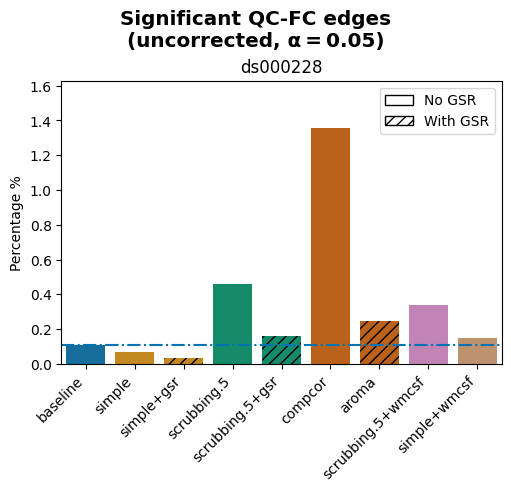

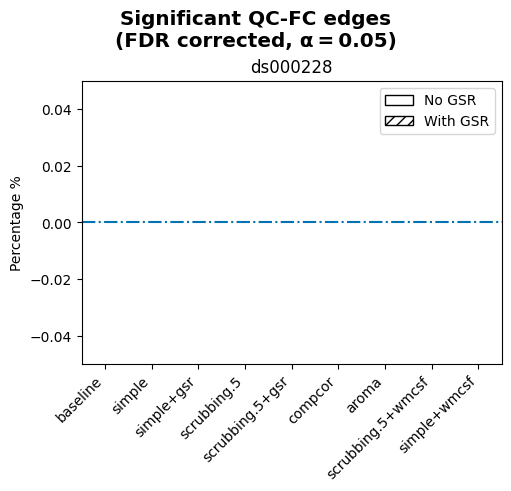

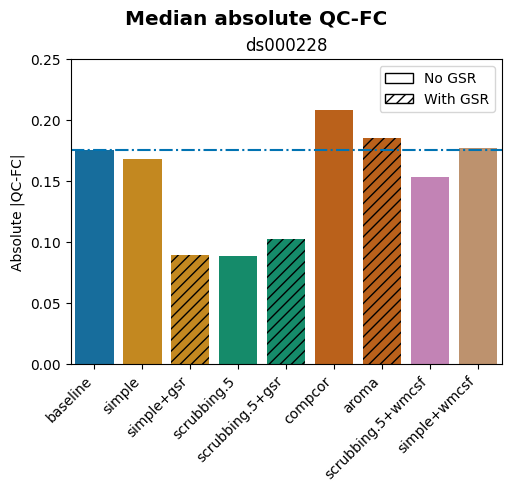

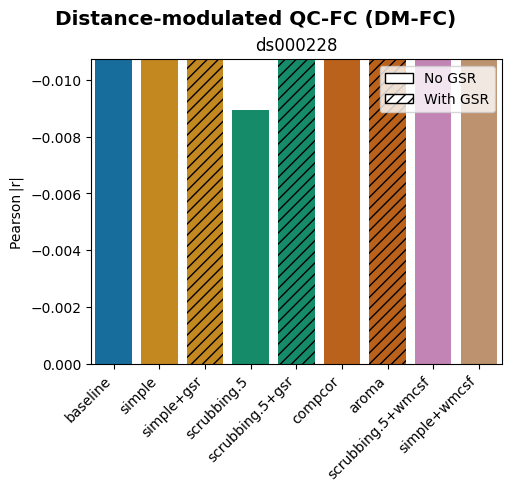

In [7]:
# -----------------------------------------------------------
# Cell 7 – generate the four QC‑FC figures
# -----------------------------------------------------------
for metric_key in ("p_values", "fdr_p_values", "median", "distance"):
    logger.info(f"Plotting {metric_key}")
    data, measure, strat_order = load_qcfc_data(
        PATH_ROOT, DATASETS, CRITERIA, FMRIPREP_VERSION, metric_key
    )

    # Optionally drop unwanted strategies
    if EXCLUDED:
        for d in data:
            data[d] = data[d].loc[~data[d]["strategy"].isin(EXCLUDED)]
        strat_order = [s for s in strat_order if s not in EXCLUDED]

    fig = plot_qcfc_stats(data, measure, strategy_order=strat_order)
    fig.show()  # inline display
    fig.savefig(f"{metric_key}_qcfc.png", dpi=300, transparent=True)